In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle as pkl
import os, sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append('src/src_cluster')
from shared import TrajData, evaluate, do_evaluation

In [3]:
#data_dir = 'data/data-new'
#dat_suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']
dat_name = ['Osaka', 'Glasgow', 'Edinburgh', 'Toronto', 'Melbourne']
C_SET = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]  # regularisation parameter

In [4]:
#algo = ['rand', 'pop', 'linreg', 'logreg', 'rank', 'logpwr', 'tranDP', 'tranILP', 'combDP', 'combILP', \
#        'ssvm-greedy', 'ssvm-viterbi', 'ssvm-listViterbi', 'ssvm-ILP', 'memm']
#algo_name = ['Random', 'Popularity', 'POILocationPrediction', 'POIOccurrencePrediction', 'RankSVM', 'RankLogistic', \
#             'Markov', 'MarkovPath', 'Rank+Markov', 'Rank+MarkovPath', \
#             'SSVM-Greedy', 'SSVM-Viterbi', 'SSVM-ListViterbi', 'SSVM-ILP', 'MEMM']
#metric_name = ['F$_1$', 'pairs-F$_1$', '$\\tau$']

In [5]:
algo = ['rand', 'pop', 'rank', 'ssvm-B10', 'ssvm-D10', 'ssvm-A10', 'ssvm-C10']
algo_name = ['\\textsc{Random}', '\\textsc{Popularity}', '\\textsc{PoiRank}', 
             '\\textsc{SP}', '\\texttt{SR}', '\\textsc{SPpath}', '\\textsc{SRpath}']
metric_name = ['F$_1$', 'pairs-F$_1$', '$\\tau$']

Histogram of the number of ground truths for queries.

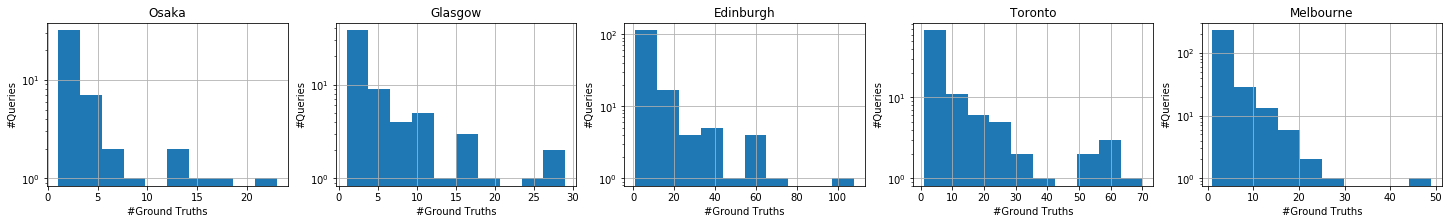

In [58]:
fig = plt.figure(figsize=[25, 3])
for dat_ix in range(len(dat_name)):
    dat_obj = TrajData(dat_ix)
    ax = plt.subplot(int('15' + str(dat_ix+1)))
    ax.set_xlabel('#Ground Truths')
    ax.set_ylabel('#Queries')
    ax.set_yscale('log')
    ax.set_title(dat_name[dat_ix])
    Y = [len(dat_obj.TRAJID_GROUP_DICT[q]) for q in dat_obj.TRAJID_GROUP_DICT]
    pd.Series(Y).hist(bins=10, ax=ax)
    fig.savefig('hist.svg')

In [ ]:
%%script false
plt.figure(figsize=[15, 5])
keys = sorted(recdict.keys())
X = np.arange(len(keys))
Y1 = [recdict[q]['C'] for q in keys]
Y2 = [recdict1[q]['C'] for q in keys]
Y3 = [recdict0[q]['C'] for q in keys]
#plt.plot(X, Y1, c='r', ls='--', marker='^', markeredgewidth=0, label='NEW-NOLOG')
plt.plot(X, Y2, c='g', ls='--', marker='v', markeredgewidth=0, label='NEW-LOG')
plt.plot(X, Y3, c='b', ls='--', marker='o', markeredgewidth=0, label='OLD-LOG')
plt.xticks(np.arange(len(keys)), [str(q) for q in keys], fontsize=10, rotation=50, horizontalalignment='right')
plt.xlim(-1, len(keys))
plt.ylim(0.001, 10000)
plt.plot([-1, len(keys)], [C_SET[0],  C_SET[0]],  c='b', ls='-')
plt.plot([-1, len(keys)], [C_SET[-1], C_SET[-1]], c='b', ls='-')
plt.yscale('log')
plt.xlabel('Query')
plt.ylabel('C')
plt.title('Values of hyper-parameter $C$')
plt.legend(loc='best')

Construct file names.

In [ ]:
def build_fnames(dat_obj, dat_ix):
    fnames = []
    for a in algo:
        fnames.append(os.path.join(dat_obj.data_dir, a + '-' + dat_obj.dat_suffix[dat_ix] + '.pkl'))
    return fnames        

In [ ]:
fnames = build_fnames(dat_obj, dat_ix)
fnames

Compute evaluation metrics.

In [ ]:
def calc_metrics(dat_obj, fnames):
    assert(len(fnames) == len(algo))
    recdicts = []
    for f in fnames:
        recdicts.append(pkl.load(open(f, 'rb')))
    
    queries = set(recdicts[0].keys())
    #print(len(keys))
    for d in recdicts[1:]:
        queries = queries & set(d.keys())
        #print(len(d.keys()))
    print('#Records:', len(queries))
    queries = sorted(queries)
    
    metrics = np.zeros((len(algo), 3, len(queries)), dtype=np.float)
    Cs = -1 * np.ones((len(algo), len(queries)), dtype=np.float)
    
    for i in range(len(recdicts)):
        d = {k:recdicts[i][k] for k in queries}
        F1_list, pF1_list, Tau_list = do_evaluation(dat_obj, d, debug=False)
        assert(len(F1_list) == len(pF1_list) == len(Tau_list) == len(queries))
        metrics[i, 0, :] = F1_list
        metrics[i, 1, :] = pF1_list
        metrics[i, 2, :] = Tau_list
        
        for k in range(len(queries)):
            q = queries[k]
            if 'C' in d[q]: Cs[i, k] = d[q]['C']
    return metrics, queries, Cs

In [ ]:
metrics, keys, Cs = calc_metrics(dat_obj, fnames)

Plot the values of metrics.

In [ ]:
%%script false
metric_ix = 0  # [F1, pairs-F1, Tau]

plt.figure(figsize=[15, 5])
X = np.arange(metrics.shape[2])
plt.plot(X, metrics[4, metric_ix, :], c='r', ls='--', marker='^', markeredgewidth=0, label='RankSVM')
plt.plot(X, metrics[12, metric_ix, :], c='g', ls='--', marker='v', markeredgewidth=0, label='SSVM-ListViterbi')
plt.xticks(np.arange(metrics.shape[2]), [str(q) for q in keys], fontsize=10, rotation=50, horizontalalignment='right')
plt.xlim(-1, metrics.shape[2])
plt.ylim(-0.1, 1.1)
plt.xlabel('Query')
plt.ylabel(metric_name[metric_ix])
plt.title('Values of evaluation metric ' + metric_name[metric_ix])
plt.legend(loc='best')

Plot values of hyper-parameters.

In [ ]:
%%script false
plt.figure(figsize=[15, 5])
X = np.arange(Cs.shape[1])
plt.plot(X, Cs[4, :], c='r', ls='--', marker='^', markeredgewidth=0, label='RankSVM')
plt.plot(X, Cs[12, :], c='g', ls='--', marker='v', markeredgewidth=0, label='SSVM-ListViterbi')
plt.xticks(np.arange(Cs.shape[1]), [str(q) for q in keys], fontsize=10, rotation=50, horizontalalignment='right')
plt.xlim(-1, Cs.shape[1])
plt.ylim(0.001, 10000)
plt.plot([-1, Cs.shape[1]], [C_SET[0],  C_SET[0]],  c='b', ls='-')
plt.plot([-1, Cs.shape[1]], [C_SET[-1], C_SET[-1]], c='b', ls='-')
plt.yscale('log')
plt.xlabel('Query')
plt.ylabel('C')
plt.title('Values of hyper-parameter $C$')
plt.legend(loc='best')

Generate LaTeX table for each dataset.

In [ ]:
def gen_latex_h(mean, stderr, title, label):
    assert(mean.shape == stderr.shape)
    assert(mean.shape == (len(algo), 3))
    
    max_1st = np.zeros(len(metric_name), dtype=np.int)
    max_2nd = np.zeros(len(metric_name), dtype=np.int)
    
    for j in range(mean.shape[1]):
        max_2nd[j], max_1st[j] = np.argsort(mean[:, j])[-2:]
    
    strs = []
    strs.append('\\begin{table*}[t]\n')
    strs.append('\\caption{' + title + '}\n')
    strs.append('\\label{' + label + '}\n')
    strs.append('\\centering\n')
    strs.append('\\begin{tabular}{l|' + (mean.shape[1])*'c' + '} \\hline\n')
    for j in range(mean.shape[1]):
        strs.append(' & ' + metric_name[j])
    strs.append(' \\\\ \\hline\n')
    for i in range(mean.shape[0]):
        strs.append(algo_name[i] + ' ')
        for j in range(mean.shape[1]):
            strs.append('& $')
            if i == max_1st[j]: strs.append('\\mathbf{')
            if i == max_2nd[j]: strs.append('\\mathit{')
            strs.append('%.3f' % mean[i, j] + '\\pm' + '%.3f' % stderr[i, j])
            if i in [max_1st[j], max_2nd[j]]: strs.append('}')
            strs.append('$ ')
        strs.append('\\\\\n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n')
    return ''.join(strs)    

In [ ]:
%%script false
mean   = np.zeros((len(algo), 3), dtype=np.float)
stderr = np.zeros((len(algo), 3), dtype=np.float)
for i in range(len(algo)):
        mean[i, 0] = np.mean(metrics[i, 0, :]); stderr[i, 0] = np.std(metrics[i, 0, :]) / np.sqrt(metrics.shape[2])
        mean[i, 1] = np.mean(metrics[i, 1, :]); stderr[i, 1] = np.std(metrics[i, 1, :]) / np.sqrt(metrics.shape[2])
        mean[i, 2] = np.mean(metrics[i, 2, :]); stderr[i, 2] = np.std(metrics[i, 2, :]) / np.sqrt(metrics.shape[2])
strs = gen_latex_h(mean, stderr, 'Performance', 'tab:performance')
print(strs)

Generate LaTeX table for each evaluation metric.

In [ ]:
def calc_metric_mean(metrics_list, metric_ix):
    assert(len(metrics_list) == len(dat_name))
    assert(type(metric_ix) == int)
    assert(0 <= metric_ix < len(metric_name))
    mean   = np.zeros((len(algo), len(dat_name)), dtype=np.float)
    stderr = np.zeros((len(algo), len(dat_name)), dtype=np.float)
    for i in range(len(algo)):
        for j in range(len(dat_name)):
            mean[i, j]   = np.mean(metrics_list[j][i, metric_ix, :])
            stderr[i, j] = np.std(metrics_list[j][i, metric_ix, :]) / np.sqrt(metrics_list[j].shape[2])
    return mean, stderr   

In [ ]:
def calc_metric_diff(metrics_list, metric_ix, baseline_ix=2):
    assert(len(metrics_list) == len(dat_name))
    assert(type(metric_ix) == int)
    assert(0 <= metric_ix < len(metric_name))
    assert(type(baseline_ix) == int)
    assert(0 <= baseline_ix < len(algo))
    diffmetrics_list = []
    for dat_ix in range(len(metrics_list)):
        diffmetrics = metrics_list[dat_ix].copy()
        for i in range(diffmetrics.shape[0]):
            diffmetrics[i, 0, :] -= metrics_list[dat_ix][baseline_ix, 0, :]
            diffmetrics[i, 1, :] -= metrics_list[dat_ix][baseline_ix, 1, :]
            diffmetrics[i, 2, :] -= metrics_list[dat_ix][baseline_ix, 2, :]
        diffmetrics_list.append(diffmetrics)
    
    diffmean   = np.zeros((len(algo), len(dat_name)), dtype=np.float)
    diffstderr = np.zeros((len(algo), len(dat_name)), dtype=np.float)
    for i in range(len(algo)):
        for j in range(len(dat_name)):
            diffmean[i, j]   = np.mean(diffmetrics_list[j][i, metric_ix, :])
            diffstderr[i, j] = np.std(diffmetrics_list[j][i, metric_ix, :]) / np.sqrt(diffmetrics_list[j].shape[2])
    return diffmean, diffstderr

In [ ]:
def gen_latex_v(mean, stderr, title, label):
    assert(mean.shape == stderr.shape)
    assert(mean.shape == (len(algo), len(dat_name)))
    
    max_1st = np.zeros(len(dat_name), dtype=np.int)
    max_2nd = np.zeros(len(dat_name), dtype=np.int)
    
    for j in range(mean.shape[1]):
        max_2nd[j], max_1st[j] = np.argsort(mean[:, j])[-2:]
    
    strs = []
    strs.append('\\begin{table*}[t]\n')
    strs.append('\\caption{' + title + '}\n')
    strs.append('\\label{' + label + '}\n')
    strs.append('\\centering\n')
    strs.append('\\begin{tabular}{l|' + (mean.shape[1])*'c' + '} \\hline\n')
    for j in range(mean.shape[1]):
        strs.append(' & ' + dat_name[j])
    strs.append(' \\\\ \\hline\n')
    for i in range(mean.shape[0]):
        strs.append(algo_name[i] + ' ')
        for j in range(mean.shape[1]):
            strs.append('& $')
            if i == max_1st[j]: strs.append('\\mathbf{')
            if i == max_2nd[j]: strs.append('\\mathit{')
            strs.append('%.3f' % mean[i, j] + '\\pm' + '%.3f' % stderr[i, j])
            if i in [max_1st[j], max_2nd[j]]: strs.append('}')
            strs.append('$ ')
        strs.append('\\\\\n')
    strs.append('\\hline\n')
    strs.append('\\end{tabular}\n')
    strs.append('\\end{table*}\n')
    return ''.join(strs)

In [ ]:
#nb_stdout = sys.stdout  # save the device for notebook output
#sys.stdout = open('/dev/stdout', 'w')  # redirect the output of %run to terminal

In [ ]:
metrics_list = []
for dat_ix in range(len(dat_name)):
    dat_obj = TrajData(dat_ix)
    fnames = build_fnames(dat_obj, dat_ix)
    metrics, keys, Cs = calc_metrics(dat_obj, fnames)
    metrics_list.append(metrics)

In [ ]:
#sys.stdout = nb_stdout  # restore the output to notebook
#sys.stdout

Evaluation metrics and difference of evaluation metrics between baseline and others.

In [ ]:
titles = ['F$_1$ score on points', 'F$_1$ score on pairs', 'Kendall\'s $\\tau$']
labels = ['tab:f1', 'tab:pf1', 'tab:tau']

In [ ]:
titles_diff = ['Difference of F$_1$ score on points from ' + baseline_algo, 
          'Difference of F$_1$ score on pairs from ' + baseline_algo, 
          'Difference of Kendall\'s $\\tau$ from ' + baseline_algo]
labels_diff = ['tab:df1', 'tab:dpf1', 'tab:dtau']

In [ ]:
baseline_ix = 2
baseline_algo = algo_name[baseline_ix]

In [ ]:
for metric_ix in range(len(metric_name)):
    mean, stderr = calc_metric_mean(metrics_list, metric_ix)
    print(gen_latex_v(mean, stderr, titles[metric_ix], labels[metric_ix]))
    diffmean, diffstderr = calc_metric_diff(metrics_list, metric_ix, baseline_ix=baseline_ix)
    print(gen_latex_v(diffmean, diffstderr, titles_diff[metric_ix], labels_diff[metric_ix]))